In [25]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t)) #number of daily clicks
        r_t = (p_t - self.cost)*d_t #p_t:conversion_probability
        return d_t, r_t

In [3]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [4]:
# From the agent's point of view, action set is [0,1]. If the actual actions are outside this
# set, we can always perform a rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

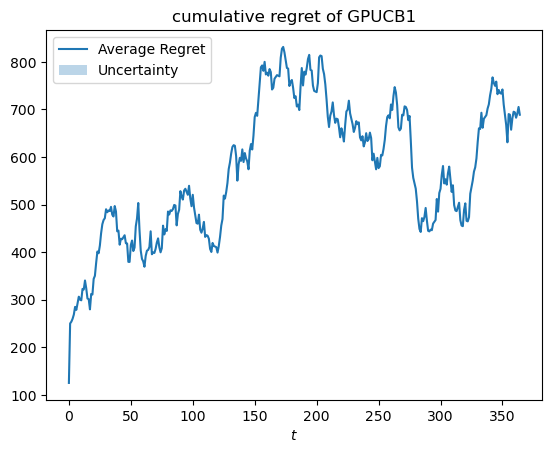

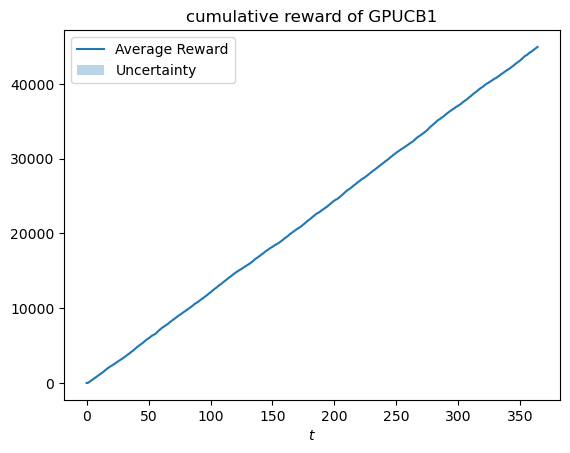

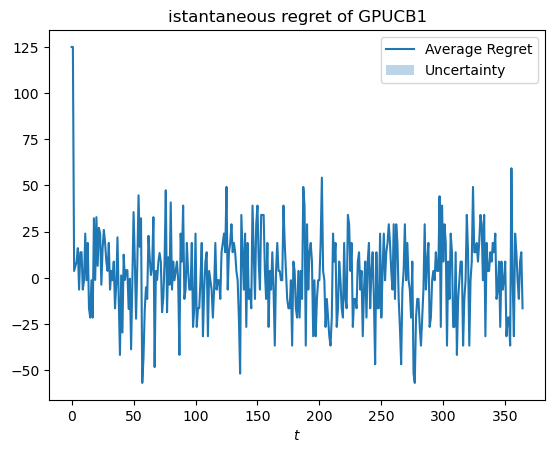

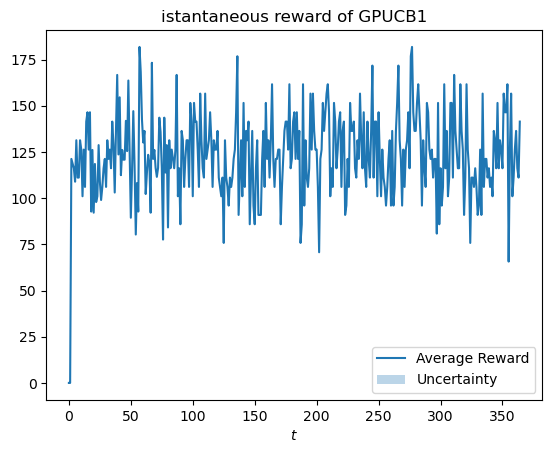

In [12]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

T = 365
min_price, max_price = 10, 20
n_customers = 100
cost = 10
agent = GPUCBAgent(T)
np.random.seed(2)
prices = np.linspace(min_price, max_price, 100)
conversion_probability = lambda p: 1-p/20
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)


reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
best_profit = profit_curve[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

agent_rewards = np.array([])

regret_per_trial = []
reward_per_trial = []
istantaneous_regret_per_trial = []
istantaneous_reward_per_trial = []
for t in range(T):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price)
    d_t, r_t = env.round(p_t, n_t=n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
regret_per_trial.append(cumulative_regret)

cumulative_reward = np.cumsum(agent_rewards)
reward_per_trial.append(cumulative_reward)

istantaneous_regret = expected_clairvoyant_rewards-agent_rewards
istantaneous_regret_per_trial.append(istantaneous_regret)

istantaneous_reward = agent_rewards
istantaneous_reward_per_trial.append(istantaneous_reward)

regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of GPUCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(T),
                average_regret+regret_sd/np.sqrt(T),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

reward_per_trial = np.array(reward_per_trial)
average_reward = reward_per_trial.mean(axis=0)
reward_sd = reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('cumulative reward of GPUCB1')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(T),
                average_reward+reward_sd/np.sqrt(T),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_regret_per_trial = np.array(istantaneous_regret_per_trial)
average_regret = istantaneous_regret_per_trial.mean(axis=0)
regret_sd = istantaneous_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('istantaneous regret of GPUCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(T),
                average_regret+regret_sd/np.sqrt(T),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_reward_per_trial = np.array(istantaneous_reward_per_trial)
average_reward = istantaneous_reward_per_trial.mean(axis=0)
reward_sd = istantaneous_reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('istantaneous reward of GPUCB1')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(T),
                average_reward+reward_sd/np.sqrt(T),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

In [40]:
class GPTSAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.N_pulls = np.zeros(discretization)
        self.t = 0

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(np.linspace(0, 1, 100).reshape(-1, 1))
        sampled_values = np.random.normal(self.mu_t, self.sigma_t)
        self.a_t = np.argmax(sampled_values)
        return self.arms[self.a_t]

In [57]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 365 #number of rounds
best_action = np.argmax(p)
print(f'Best action is {best_action}')
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

n_trials = 100 # number of bids

Best action is 2


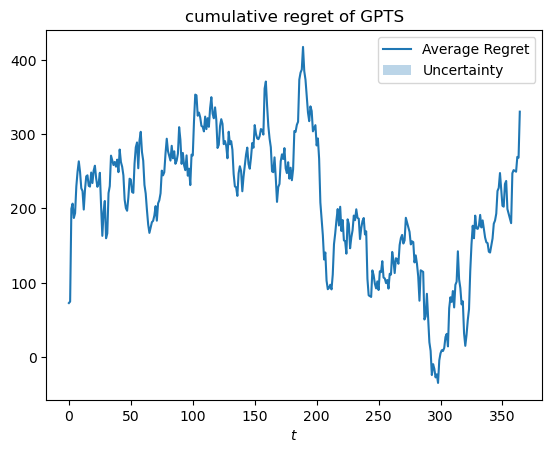

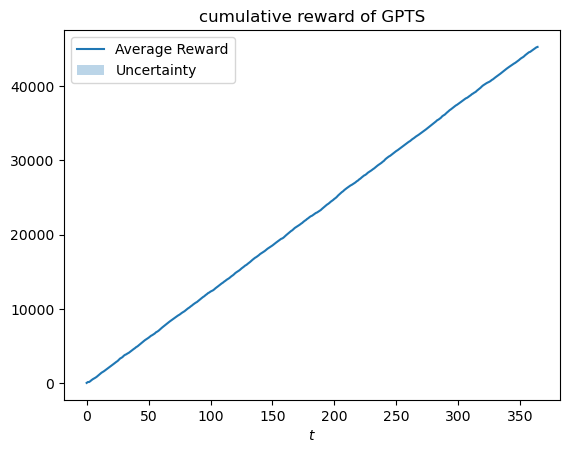

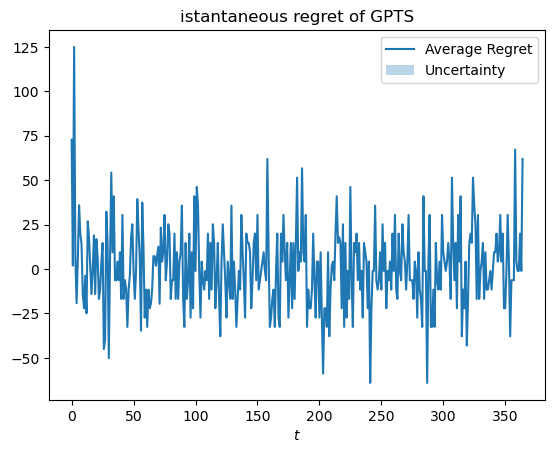

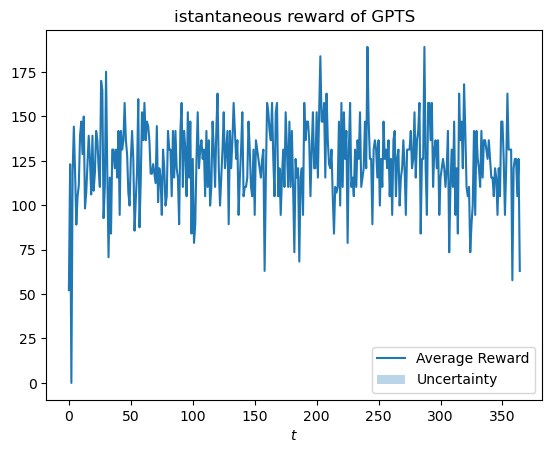

In [41]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

T = 365
min_price, max_price = 10, 20
n_customers = 100
cost = 10
agent = GPTSAgent(T)
np.random.seed(2)
prices = np.linspace(min_price, max_price, 100)
conversion_probability = lambda p: 1-p/20
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)


reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
best_profit = profit_curve[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

agent_rewards = np.array([])

regret_per_trial = []
reward_per_trial = []
istantaneous_regret_per_trial = []
istantaneous_reward_per_trial = []
for t in range(T):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price)
    d_t, r_t = env.round(p_t, n_t=n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
regret_per_trial.append(cumulative_regret)

cumulative_reward = np.cumsum(agent_rewards)
reward_per_trial.append(cumulative_reward)

istantaneous_regret = expected_clairvoyant_rewards-agent_rewards
istantaneous_regret_per_trial.append(istantaneous_regret)

istantaneous_reward = agent_rewards
istantaneous_reward_per_trial.append(istantaneous_reward)

regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of GPTS')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(T),
                average_regret+regret_sd/np.sqrt(T),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

reward_per_trial = np.array(reward_per_trial)
average_reward = reward_per_trial.mean(axis=0)
reward_sd = reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('cumulative reward of GPTS')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(T),
                average_reward+reward_sd/np.sqrt(T),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_regret_per_trial = np.array(istantaneous_regret_per_trial)
average_regret = istantaneous_regret_per_trial.mean(axis=0)
regret_sd = istantaneous_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('istantaneous regret of GPTS')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(T),
                average_regret+regret_sd/np.sqrt(T),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_reward_per_trial = np.array(istantaneous_reward_per_trial)
average_reward = istantaneous_reward_per_trial.mean(axis=0)
reward_sd = istantaneous_reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('istantaneous reward of GPTS')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(T),
                average_reward+reward_sd/np.sqrt(T),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

NameError: name 'plt' is not defined